In [58]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as mplot
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report,accuracy_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.svm import OneClassSVM
import torch
import torch.optim as optim
import torch.nn as nn

In [2]:
sensor_df = pd.read_csv("sensor.csv")
print(sensor_df.head())
#Show column name
print(sensor_df.columns)

   Unnamed: 0            timestamp  sensor_00  sensor_01  sensor_02  \
0           0  2018-04-01 00:00:00   2.465394   47.09201    53.2118   
1           1  2018-04-01 00:01:00   2.465394   47.09201    53.2118   
2           2  2018-04-01 00:02:00   2.444734   47.35243    53.2118   
3           3  2018-04-01 00:03:00   2.460474   47.09201    53.1684   
4           4  2018-04-01 00:04:00   2.445718   47.13541    53.2118   

   sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  \
0  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
1  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
2  46.397570   638.8889   73.54598   13.32465   16.03733  ...   41.66666   
3  46.397568   628.1250   76.98898   13.31742   16.24711  ...   40.88541   
4  46.397568   636.4583   76.58897   13.35359   16.21094  ...   41.40625   

   sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
0  39.641200   65.68287   50.92593  38.194440

In [3]:
#Remove unnamed column
sensor_df = sensor_df.loc[:, ~sensor_df.columns.str.contains('^Unnamed')]

#Backfill and forward fill data for missing values
sensor_df.loc[:, sensor_df.columns] =  sensor_df.loc[:, sensor_df.columns].ffill()
sensor_df.loc[:, sensor_df.columns] =  sensor_df.loc[:, sensor_df.columns].bfill()

#Update timestamp from string to datetime
sensor_df['timestamp'] = pd.to_datetime(sensor_df['timestamp'])

#Drop columns with no data
columns_no_data =  sensor_df.columns[sensor_df.isnull().any()].tolist()
sensor_df = sensor_df.drop(columns_no_data, axis=1)

In [4]:
#Update string machinee status with 0 and 1
machine_status_dict = {"BROKEN":True, "NORMAL":False, "RECOVERING":False}
sensor_df = sensor_df.replace({"machine_status":machine_status_dict})


C:\Users\Abhilash\AppData\Local\Temp\ipykernel_51812\3561595395.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sensor_df = sensor_df.replace({"machine_status":machine_status_dict})


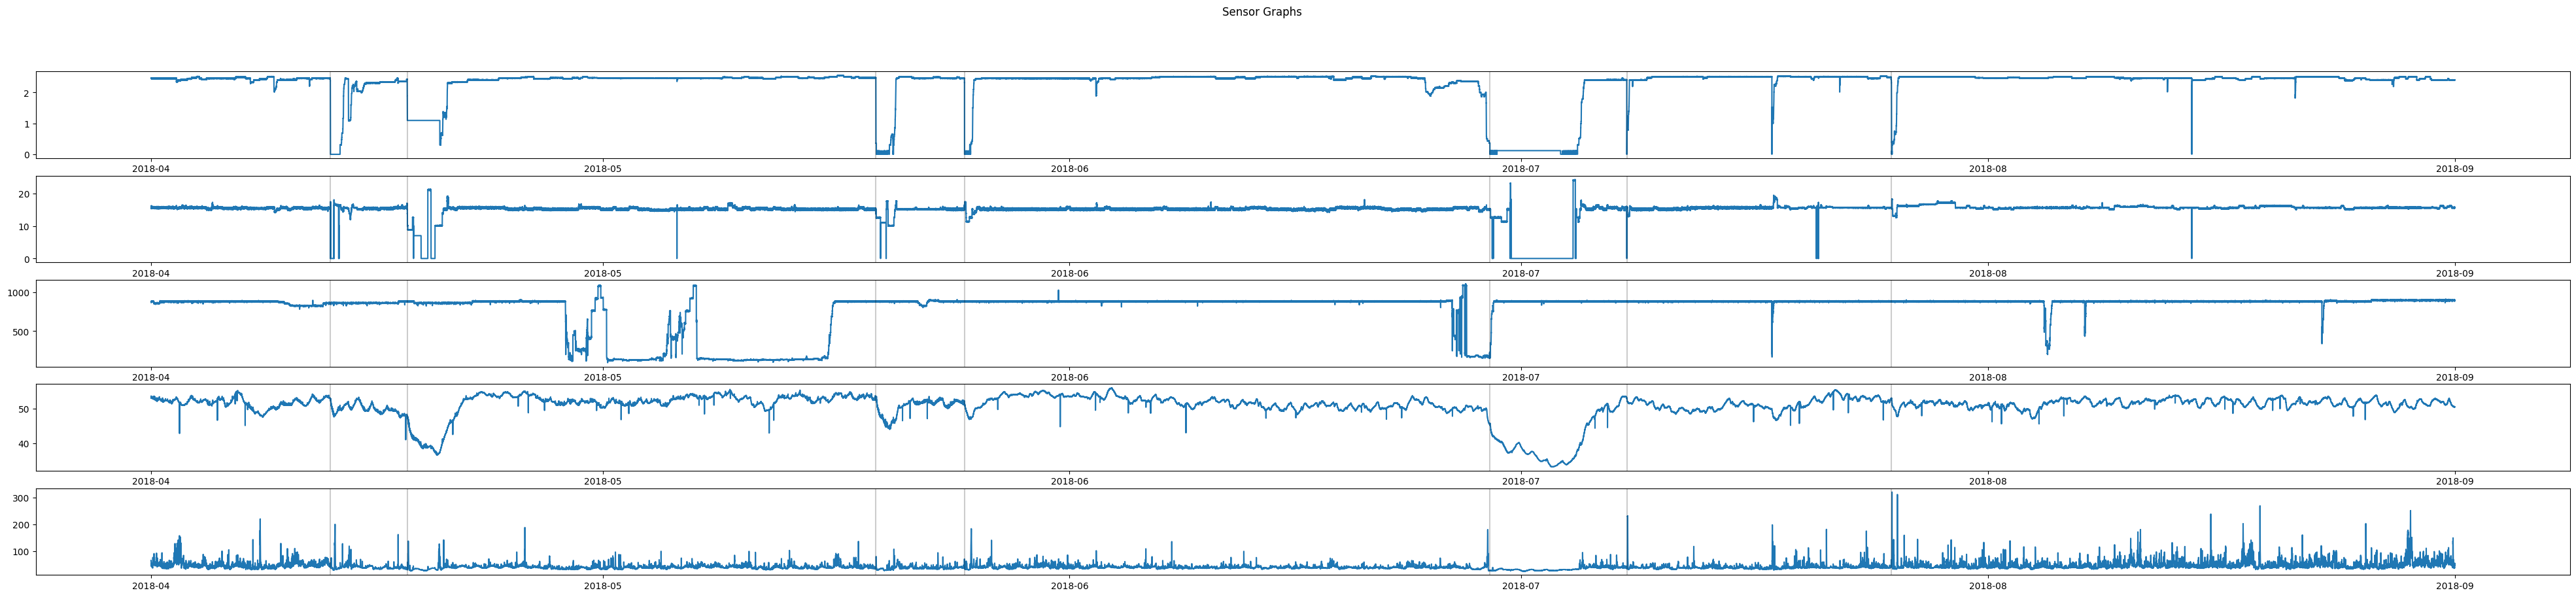

In [5]:
#Get timestamps of broken status
timestamps_to_highlight = sensor_df[sensor_df["machine_status"] == 1]["timestamp"].to_numpy()

#Plot trend and mark broken timestamps
fig, (ax1, ax2, ax3, ax4, ax5) = mplot.subplots(5, figsize=(50, 10))
fig.suptitle('Sensor Graphs')


ax1.plot(sensor_df.timestamp, sensor_df.sensor_00)
ax2.plot(sensor_df.timestamp, sensor_df.sensor_08)
ax3.plot(sensor_df.timestamp, sensor_df.sensor_21)
ax4.plot(sensor_df.timestamp, sensor_df.sensor_02)
ax5.plot(sensor_df.timestamp, sensor_df.sensor_45)

for i in range(len(timestamps_to_highlight)):
    ax1.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    ax2.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    ax3.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    ax4.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    ax5.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)



In [6]:
#Initialize device (hardware) to train on
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(device)

cuda


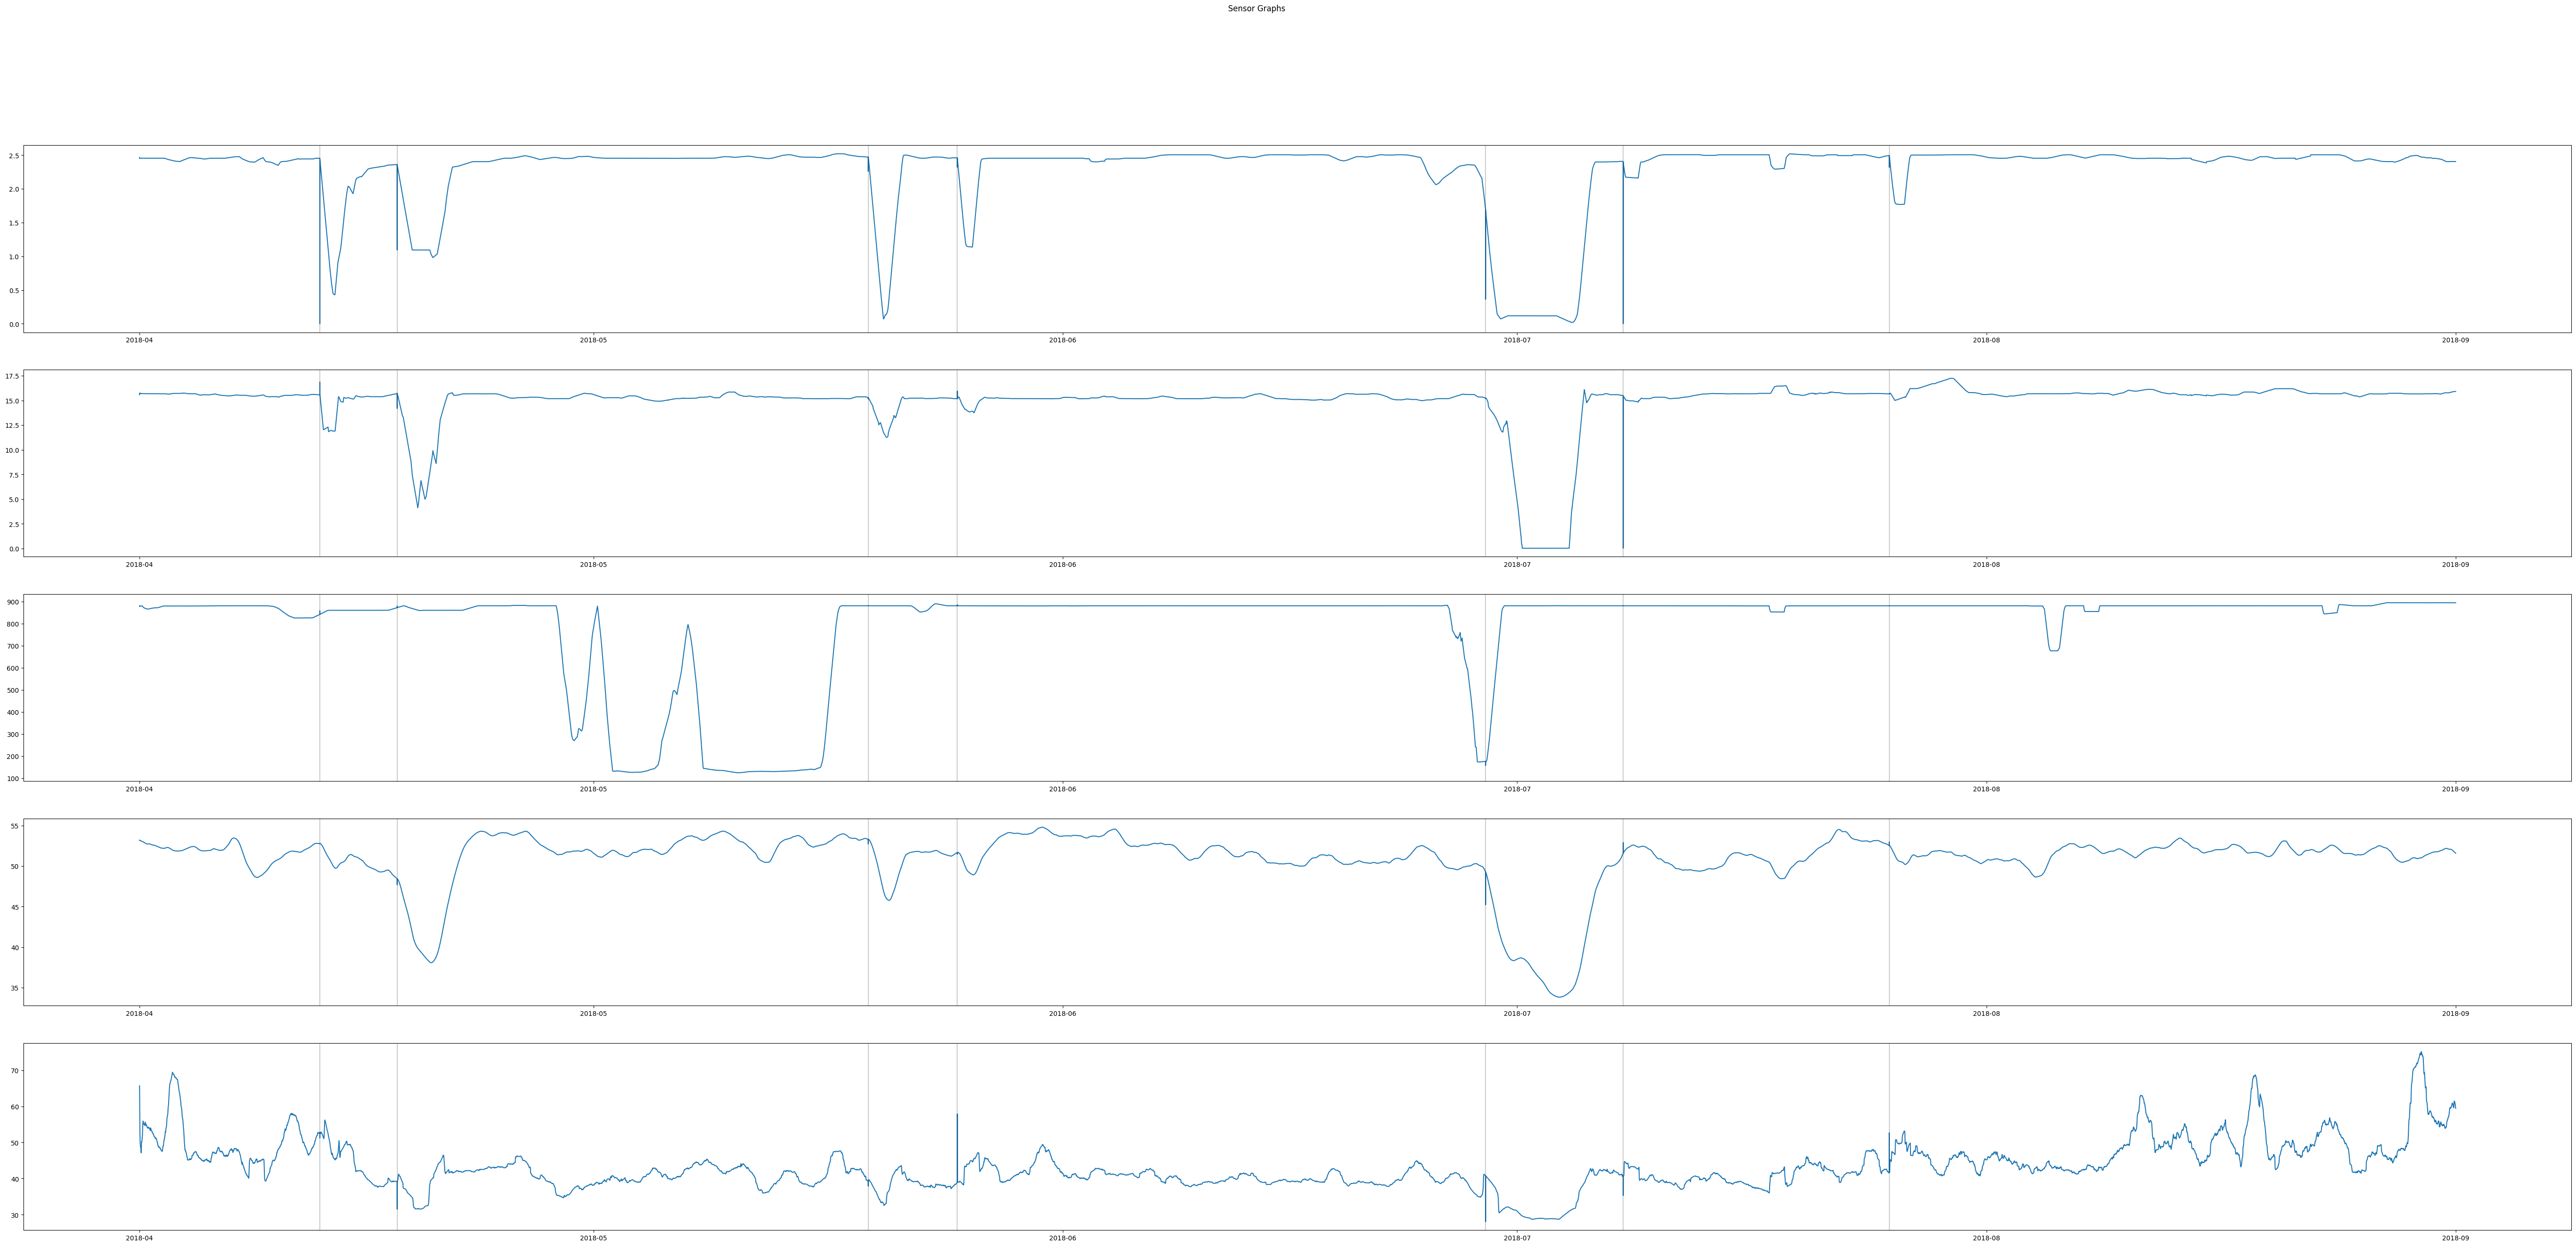

In [7]:

#Smoothen the data by calculating moving average of 1 day since granularity of sensor data is 1 min. Could try with 2 days of moving avg as well.

moving_df = sensor_df.set_index('timestamp').groupby(['machine_status']).rolling('1d').mean().reset_index()
moving_df = moving_df.sort_values(by='timestamp')
moving_good_df = moving_df[moving_df["machine_status"] == 0][moving_df.columns[2:]]
moving_bad_df = moving_df[moving_df["machine_status"] == 1][moving_df.columns[2:]]

#For neural networks
train_X = torch.tensor(sensor_df[sensor_df["timestamp"] <= timestamps_to_highlight[3]][moving_df.columns[2:]].to_numpy(), device=device)
train_Y = sensor_df[sensor_df["timestamp"] <= timestamps_to_highlight[3]]["machine_status"].to_numpy()
train_Y = train_Y.reshape(len(train_Y),1).astype(float)
train_Y = torch.tensor(train_Y, device=device)

test_X = torch.tensor(sensor_df[sensor_df["timestamp"] > timestamps_to_highlight[3]][moving_df.columns[2:]].to_numpy(), device=device)
test_Y = sensor_df[sensor_df["timestamp"] > timestamps_to_highlight[3]]["machine_status"].to_numpy()
test_Y = test_Y.reshape(len(test_Y), 1).astype(float)
test_Y = torch.tensor(test_Y, device=device)

fig, (ax1, ax2, ax3, ax4, ax5) = mplot.subplots(5, figsize=(70, 30))
fig.suptitle('Sensor Graphs')


ax1.plot(moving_df.timestamp, moving_df.sensor_00)
ax2.plot(moving_df.timestamp, moving_df.sensor_08)
ax3.plot(moving_df.timestamp, moving_df.sensor_21)
ax4.plot(moving_df.timestamp, moving_df.sensor_02)
ax5.plot(moving_df.timestamp, moving_df.sensor_45)

for i in range(len(timestamps_to_highlight)):
    ax1.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    ax2.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    ax3.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    ax4.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    ax5.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)

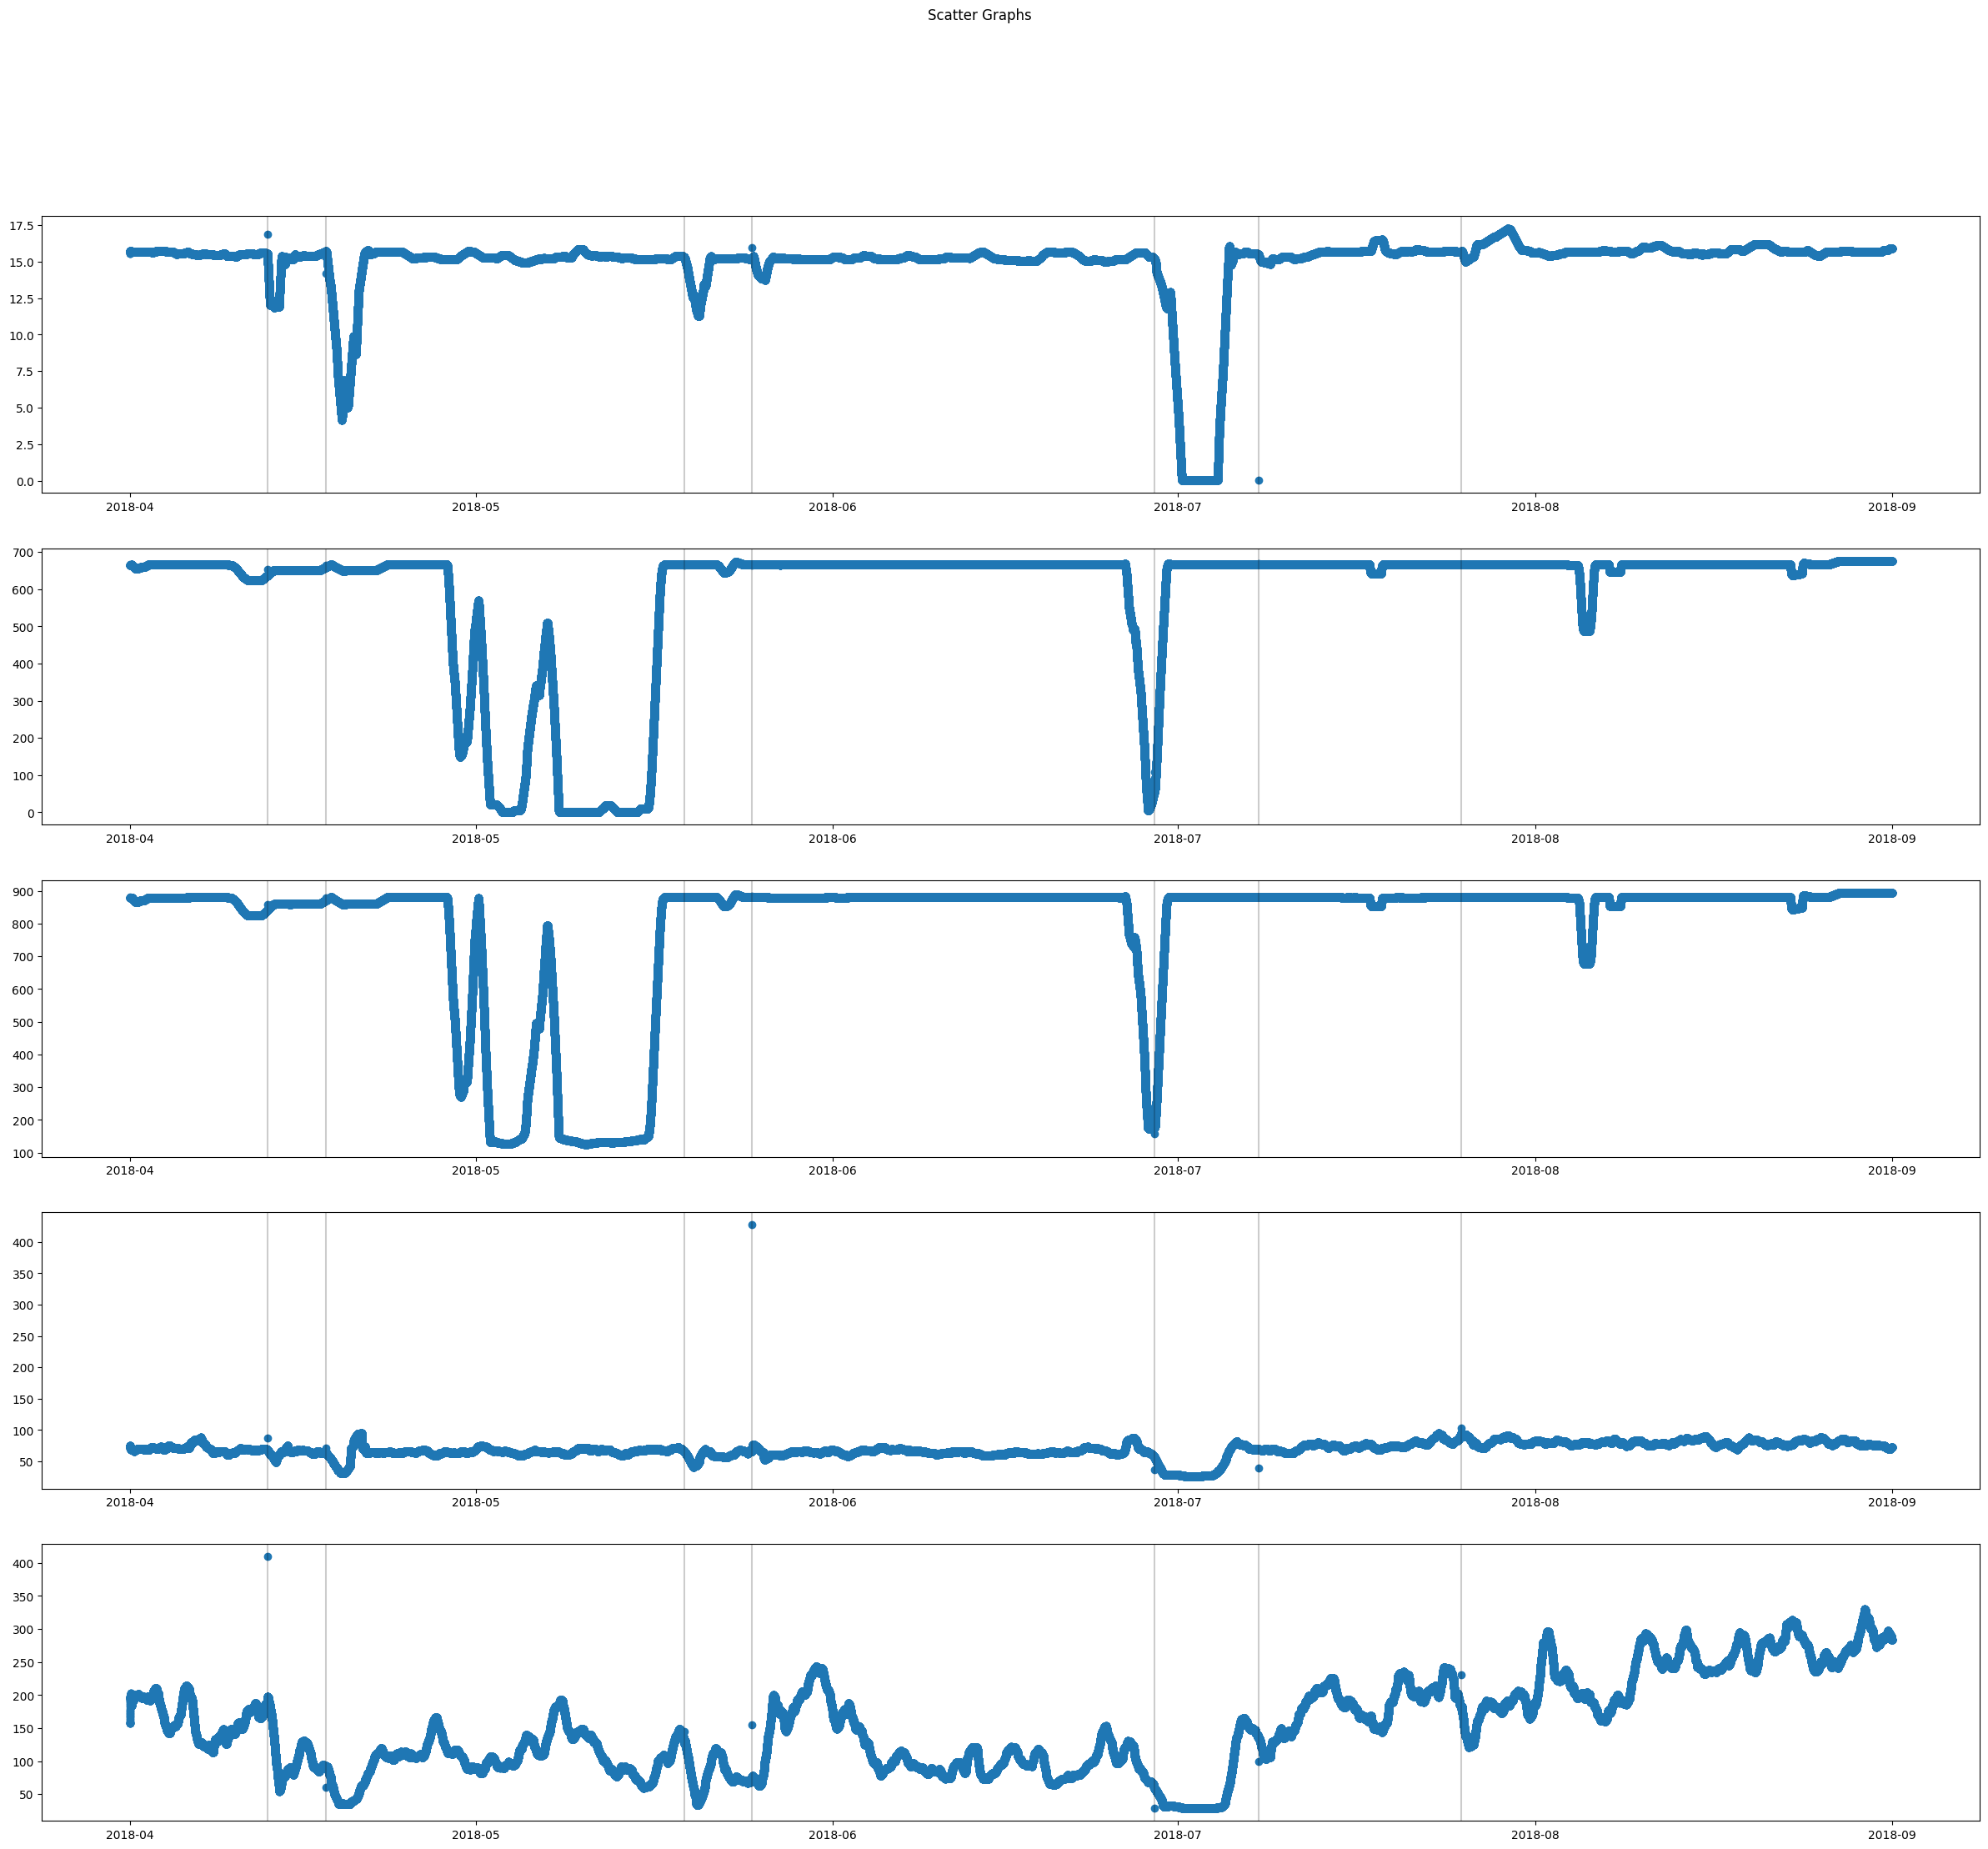

In [8]:
#Scatter plot against timestamp
scatter_fig, (s1, s2, s3, s4, s5) = mplot.subplots(5, figsize=(30, 25))
scatter_fig.suptitle('Scatter Graphs')

s1.scatter(moving_df.timestamp, moving_df.sensor_08)
s2.scatter(moving_df.timestamp, moving_df.sensor_19)
s3.scatter(moving_df.timestamp, moving_df.sensor_21)
s4.scatter(moving_df.timestamp, moving_df.sensor_40)
s5.scatter(moving_df.timestamp, moving_df.sensor_48)

for i in range(len(timestamps_to_highlight)):
    s1.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    s2.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    s3.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    s4.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    s5.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)

mplot.show()

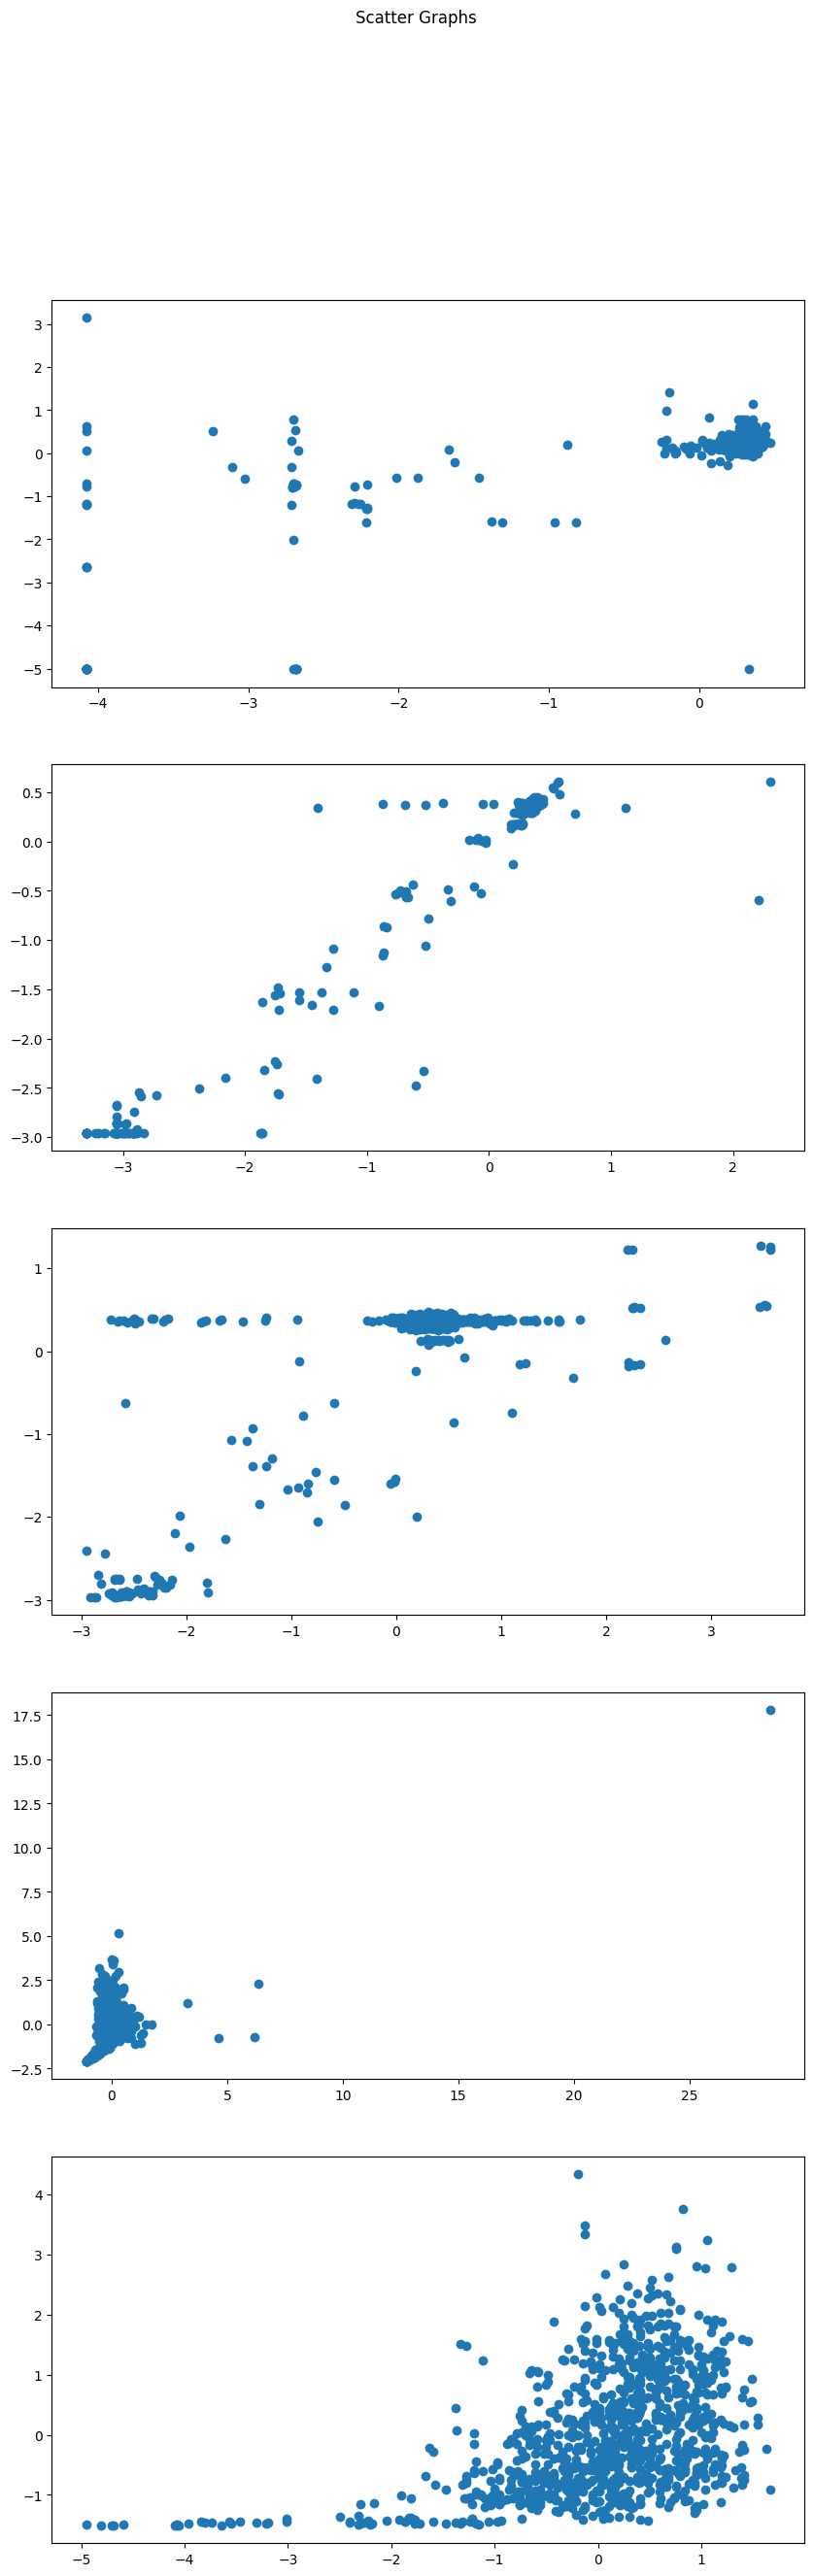

In [9]:
#Normalize the data
to_be_normalized = sensor_df[moving_df.columns[2:]]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(to_be_normalized)
scaled_data = pd.DataFrame(scaled_data, columns=moving_df.columns[2:])
scaled_data["timestamp"] = sensor_df.timestamp
scaled_data["machine_status"] = sensor_df.machine_status

#Scatter plot against sensors
scatter_fig, (s1, s2, s3, s4, s5) = mplot.subplots(5, figsize=(10, 30))
scatter_fig.suptitle('Scatter Graphs')

#Pick a sample from the scaled dataset
sample = scaled_data.sample(n=1000)

s1.scatter(sample.sensor_04, sample.sensor_08)
s2.scatter(sample.sensor_16, sample.sensor_19)
s3.scatter(sample.sensor_30, sample.sensor_21)
s4.scatter(sample.sensor_39, sample.sensor_40)
s5.scatter(sample.sensor_03, sample.sensor_48)

mplot.show()

In [10]:
#Prepare data for isolation forest

iso_train_df = sensor_df[sensor_df["timestamp"] <= timestamps_to_highlight[3]][moving_df.columns[2:]]
iso_test_df = sensor_df[sensor_df["timestamp"] > timestamps_to_highlight[3]][moving_df.columns[2:]]
test_data_timestamps = sensor_df[sensor_df["timestamp"] > timestamps_to_highlight[3]]["timestamp"]
test_data_timestamps_to_highlight = timestamps_to_highlight[-4:]

verification_data=sensor_df.copy()

replacement_status_dict = {True:-1, False:1}
iso_verification_data = verification_data.replace({"machine_status":replacement_status_dict})

iso_verification_y_train = verification_data[verification_data["timestamp"] <= timestamps_to_highlight[3]]["machine_status"]
iso_verification_y_test = verification_data[verification_data["timestamp"] > timestamps_to_highlight[3]]["machine_status"]


C:\Users\Abhilash\AppData\Local\Temp\ipykernel_51812\3906422272.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  iso_verification_data = verification_data.replace({"machine_status":replacement_status_dict})


In [11]:
#Scatter plots for Isolation Forest
def ScatterPlotAgainstTime(X_data, Y_data, highlight_points, indices):
    scatter_fig, (s1, s2, s3, s4, s5) = mplot.subplots(5, figsize=(30, 25))
    scatter_fig.suptitle('Scatter plots for Isolation Forest')

    s1.scatter(X_data, Y_data.sensor_05)
    s2.scatter(X_data, Y_data.sensor_12)
    s3.scatter(X_data, Y_data.sensor_24)
    s4.scatter(X_data, Y_data.sensor_43)
    s5.scatter(X_data, Y_data.sensor_50)

    s1.scatter(X_data.to_numpy()[indices,], Y_data.sensor_05.to_numpy()[indices,], edgecolors="r")
    s2.scatter(X_data.to_numpy()[indices,], Y_data.sensor_12.to_numpy()[indices,], edgecolors="r")
    s3.scatter(X_data.to_numpy()[indices,], Y_data.sensor_24.to_numpy()[indices,], edgecolors="r")
    s4.scatter(X_data.to_numpy()[indices,], Y_data.sensor_43.to_numpy()[indices,], edgecolors="r")
    s5.scatter(X_data.to_numpy()[indices,], Y_data.sensor_50.to_numpy()[indices,], edgecolors="r")

    for i in range(len(highlight_points)):
        s1.axvline(pd.Timestamp(highlight_points[i]), linestyle='solid', color='black', alpha=0.2)
        s2.axvline(pd.Timestamp(highlight_points[i]), linestyle='solid', color='black', alpha=0.2)
        s3.axvline(pd.Timestamp(highlight_points[i]), linestyle='solid', color='black', alpha=0.2)
        s4.axvline(pd.Timestamp(highlight_points[i]), linestyle='solid', color='black', alpha=0.2)
        s5.axvline(pd.Timestamp(highlight_points[i]), linestyle='solid', color='black', alpha=0.2)

    mplot.show()

Train accuracy : 5.141983005746166e-05
Test accuracy : 2.1048348055483444e-05


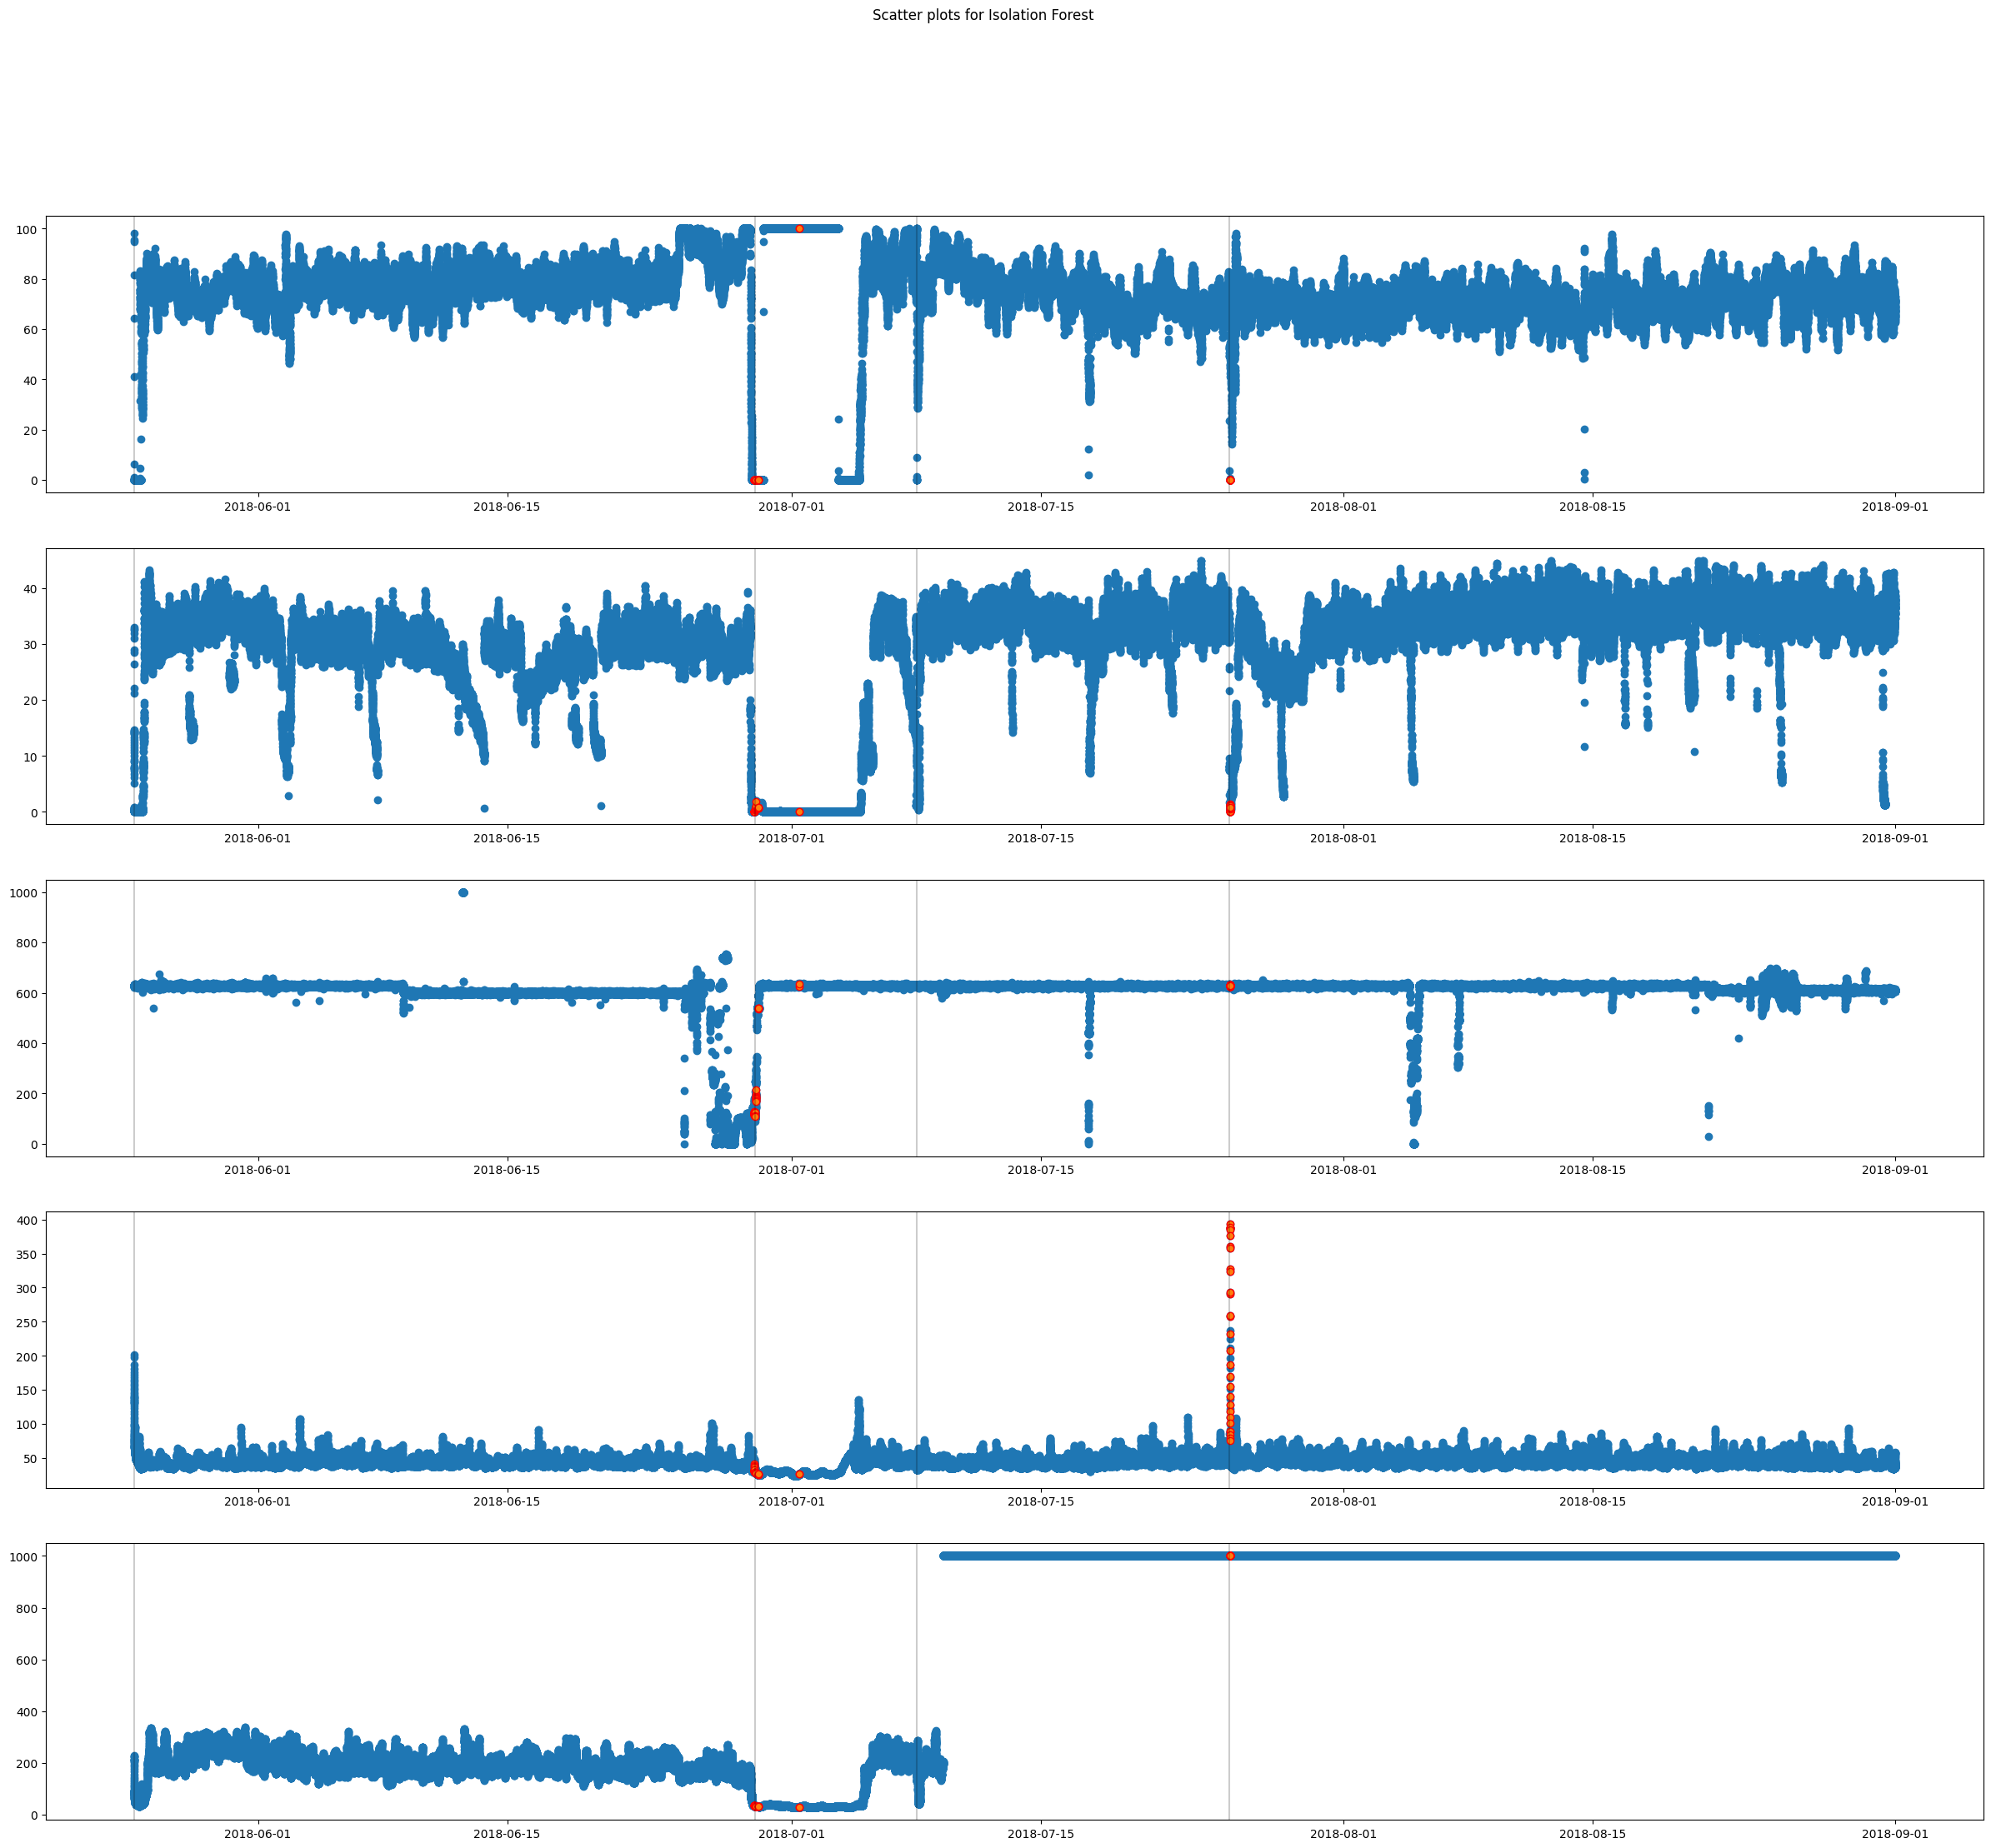

In [12]:
#Isolation Forest 

broken = 3
contamination = broken/len(iso_train_df)
iso_algo = IsolationForest(contamination=contamination, random_state=100, max_features=45)
iso_model = iso_algo.fit(iso_train_df)
train_predictions = iso_model.predict(iso_train_df)

train_accuracy = float((train_predictions == iso_verification_y_train).mean())

print(f"Train accuracy : {train_accuracy}")

test_predictions = iso_model.predict(iso_test_df)

test_accuracy = float((test_predictions == iso_verification_y_test).mean())
indices = np.where(test_predictions < 0)
print(f"Test accuracy : {test_accuracy}")

ScatterPlotAgainstTime(test_data_timestamps, iso_test_df, test_data_timestamps_to_highlight, indices)

In [13]:
#Prepare data for Kmeans
kmeans_train_df = sensor_df[sensor_df["timestamp"] <= timestamps_to_highlight[3]][moving_df.columns[2:]]
kmeans_test_df = sensor_df[sensor_df["timestamp"] > timestamps_to_highlight[3]][moving_df.columns[2:]]
test_data_timestamps = sensor_df[sensor_df["timestamp"] > timestamps_to_highlight[3]]["timestamp"]
test_data_timestamps_to_highlight = timestamps_to_highlight[-4:]

verification_data=sensor_df.copy()

replacement_status_dict = {True:1, False:0}
kmeans_verification_data = verification_data.replace({"machine_status":replacement_status_dict})

kmeans_verification_y_train = verification_data[verification_data["timestamp"] <= timestamps_to_highlight[3]]["machine_status"]
kmeans_verification_y_test = verification_data[verification_data["timestamp"] > timestamps_to_highlight[3]]["machine_status"]

C:\Users\Abhilash\AppData\Local\Temp\ipykernel_51812\1593690534.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  kmeans_verification_data = verification_data.replace({"machine_status":replacement_status_dict})


In [14]:
#Use KMeans
kmeans_algo = KMeans(n_clusters=2, random_state=1234, n_init=51, max_iter=500).fit(kmeans_train_df)
train_predictions = kmeans_algo.predict(kmeans_train_df)
test_predictions = kmeans_algo.predict(kmeans_test_df)

train_accuracy = float((train_predictions == kmeans_verification_y_train).mean())
test_accuracy = float((test_predictions == kmeans_verification_y_test).mean())



clusters = kmeans_algo.cluster_centers_
print(f"Cluster Shape {clusters.shape}")
print(f"Train Accuracy : {train_accuracy} Test Accuracy:{test_accuracy}")


Cluster Shape (2, 51)
Train Accuracy : 0.7347122417760409 Test Accuracy:0.9793726189056262


In [ ]:
#Use mini batch kmeans
batch_size = 2000
mini_Kmeans = MiniBatchKMeans(batch_size=batch_size, random_state=1234)
mini_Kmeans_model = None
number_batches = int(math.ceil(len(kmeans_train_df) / batch_size))
start = 0
end = start + batch_size

print(number_batches)

for i in range(number_batches):
    mini_Kmeans_model = mini_Kmeans.partial_fit(kmeans_train_df[start:end])
    start = start + batch_size
    end = start + batch_size


train_predictions = mini_Kmeans_model.predict(kmeans_train_df)
test_predictions = mini_Kmeans_model.predict(kmeans_test_df)

print(mini_Kmeans_model.cluster_centers_)

39
8


In [48]:
svm_train = scaled_data[scaled_data["timestamp"] <= timestamps_to_highlight[3]][moving_df.columns[2:]]
svm_test = scaled_data[scaled_data["timestamp"] > timestamps_to_highlight[3]][moving_df.columns[2:]]

svm_model = OneClassSVM(nu=1.01e-01, kernel="poly", max_iter=1000)
svm_model.fit(svm_train)
train_predictions = svm_model.predict(svm_train)
test_predictions = svm_model.predict(svm_test)

updated_train_predictions = pd.Series(train_predictions).replace([-1,1],[1,0])
updated_test_predictions = pd.Series(test_predictions).replace([-1,1],[1,0])
test_accuracy = accuracy_score(updated_test_predictions, scaled_data[scaled_data["timestamp"] > timestamps_to_highlight[3]]["machine_status"])
train_accuracy = accuracy_score(updated_train_predictions, scaled_data[scaled_data["timestamp"] <= timestamps_to_highlight[3]]["machine_status"])


d:\Sensor ML Project\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [49]:
print(train_accuracy)
print(test_accuracy)

0.36803743363628183
0.03691178637329947


In [18]:

def get_sequential(train_data, sequence_length):
    # Create sequences
    sequences = []
    target = []

    data = train_data[train_data.columns[2:]].to_numpy()
    category_data = train_data["machine_status"].to_numpy()

    for i in range(len(train_data) - sequence_length):
        sequences.append(data[i:i + sequence_length,])
        target.append(category_data[i + sequence_length,])
    
    x = np.array(sequences)
    y = np.array(target)
    return x, y


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        print()
    
    def forward(self, x):
        print()


copied_data = moving_df.copy()
machine_status_dict = {"BROKEN":True, "NORMAL":False, "RECOVERING":False}
copied_data = copied_data.replace({"machine_status":machine_status_dict})

#Use until 3rd failure
train_data = copied_data[copied_data["timestamp"] <= timestamps_to_highlight[3]]
test_data = copied_data[copied_data["timestamp"] > timestamps_to_highlight[3]]


# Parameters
sequence_length = 60  # Define the sequence length (how many time steps to consider)

# Create sequences
sequences = []
target = []

#sensor_data = train_data[train_data.columns[2:]].to_numpy()


x_train, y_train = get_sequential(train_data, sequence_length)
x_test, y_test= get_sequential(test_data, sequence_length)

x_train_torch = torch.tensor(x_train[:, :, None], dtype=torch.float32)
y_train_torch = torch.tensor(y_train[:, None], dtype=torch.bool)



In [19]:
class BinaryClassificationNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.predictor = nn.Sequential(
            nn.Linear(51,17),
            nn.ReLU(),
            nn.Linear(17,4),
            nn.ReLU(),
            nn.Linear(4,1),
            nn.Sigmoid()
        )
        self.double()

    def forward(self, x):
        logits =  self.predictor(x)
        return logits

epochs = 1000

#set best accuracy to really really low value 
best_acc = -np.inf
best_weights = None

model = BinaryClassificationNeuralNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)    
loss_fn = nn.BCELoss()  # binary cross entropy
batch_size = 10000
batch_start = torch.arange(0, len(train_X), batch_size)

for epoch in range(epochs):
    model.train()

    for start in range(len(batch_start)):
        batch_x = train_X[start:start+batch_size]
        batch_y = train_Y[start:start+batch_size]
        predictions = model(batch_x)    
        loss = loss_fn(predictions, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    model.eval()
    predictions = model(train_X)
    accuracy=float((predictions.round() == train_Y).float().mean())

    if(accuracy > best_acc):
        best_acc = accuracy
        best_weights = model.state_dict()
    
    print(f"EPOCH {epoch}  | Current best accuracy {best_acc}")
    
print(f"Final accuracy {best_acc}")

model.load_state_dict(best_weights)

#Test it against test data
test_predictions = model(test_X)
accuracy = float((test_predictions.round() == test_Y).float().mean())

print(f"Accuracy on test data {accuracy}")



EPOCH 0  | Current best accuracy 0.9999485611915588
EPOCH 1  | Current best accuracy 0.9999485611915588
EPOCH 2  | Current best accuracy 0.9999485611915588
EPOCH 3  | Current best accuracy 0.9999485611915588
EPOCH 4  | Current best accuracy 0.9999485611915588
EPOCH 5  | Current best accuracy 0.9999485611915588
EPOCH 6  | Current best accuracy 0.9999485611915588
EPOCH 7  | Current best accuracy 0.9999485611915588
EPOCH 8  | Current best accuracy 0.9999485611915588
EPOCH 9  | Current best accuracy 0.9999485611915588
EPOCH 10  | Current best accuracy 0.9999485611915588
EPOCH 11  | Current best accuracy 0.9999485611915588
EPOCH 12  | Current best accuracy 0.9999485611915588
EPOCH 13  | Current best accuracy 0.9999485611915588
EPOCH 14  | Current best accuracy 0.9999485611915588
EPOCH 15  | Current best accuracy 0.9999485611915588
EPOCH 16  | Current best accuracy 0.9999485611915588
EPOCH 17  | Current best accuracy 0.9999485611915588
EPOCH 18  | Current best accuracy 0.9999485611915588
EPO

In [20]:
tr = test_predictions.cpu().detach().numpy()
s = tr[tr.round() == 0]
print(len(tr))
print(len(s))


142529
142507
